## Introduction
Leverage is a powerful tool to magnify performance of a portoflio, but it comes at the price of increased risk. In this brief study we take into consideration a daily-rebalanced leveraged ETF (LETF). Being daily re-leveraged, LETFs are negatevely affected by periods of high volatility (see, e.g., Ref. 1). On the other hand, LETFs benefit from long streaks of days characterized by low volatility and positive returns. The purpose of this work is to evaluate a possible strategy to identiy period of low volatility, where LETFs can outperform their underlying index.

### Disclaimer
The content provided here is published for educational purposes only. It does not constitute financial advice or investment recommendations.

## Methods
The strategy here analyzed consists of rotating between a LETF and short term bonds depending on wheter the LETFS underlying index is above or below its moving average (different moving average periods are considered). We consider the index NASDAQ100, and two LETFS: a 2x leveraged (*Amundi Nasdaq-100 2x Daily Leveraged*, ticker: LQQ.PA) and a 3x leveraged (*WisdomTree NASDAQ 100 3x Daily Leveraged*, ticker: QQQ3.MI).

## Analysis of the volatility
We analyze the volatility of the index NASDAQ100 from the 01/01/1990 to the 01/10/2024. Given a moving average window T, we evaluate the volatility of the index separating the periods when it is above its moving average and below it.

<img src="leveraged_portfolio_analysis_volatility_comparison.png" height="400" />

Numerical results of a Mann-Whitney *U Test* are reported in the code below. As already evident from the figure, the index exhibit **lower volatility when it moves above its rolling average**.

## Analysis of the strategy
 

In [1]:
# Import the libraries
import matplotlib.pyplot as plt
import yfinance as yf
import numpy    as np
import pandas   as pd
import seaborn  as sns
import scipy


[*********************100%***********************]  1 of 1 completed


 50-days period:  Above m.m.   | Below m.m.
     Volatility:  19.05%       | 27.58%
     pvalue:      1.1181049197977658e-09
 
100-days period:  Above m.m.   | Below m.m.
     Volatility:  19.84%       | 30.41%
     pvalue:      2.336177705793029e-16
 
200-days period:  Above m.m.   | Below m.m.
     Volatility:  22.16%       | 31.33%
     pvalue:      1.576857443338311e-18
 
300-days period:  Above m.m.   | Below m.m.
     Volatility:  20.34%       | 31.52%
     pvalue:      1.3274920818640852e-20
 


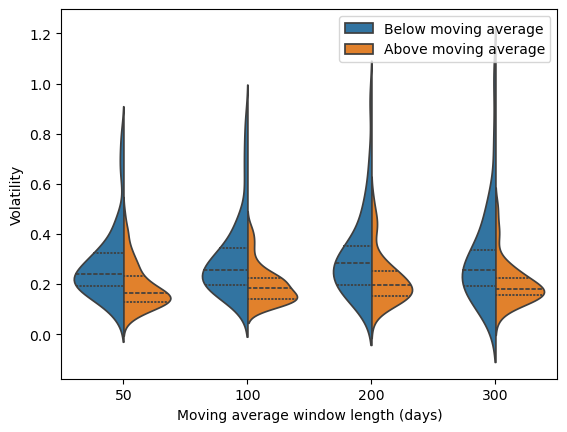

In [17]:
'''
Compare the volatility of ^NDX during periods when it is above its moving average versus when it is below, across various moving average window lengths.
Produce a violin plot.
'''

data = yf.download('^NDX',group_by='Date', start="1990-01-01", end="2024-10-01")
data['Pct Change'] = data['Adj Close'].pct_change()

# We compare the volatility of the index in two situations: when it is above its moving average and below it
window_lengths = [50, 100, 200, 300]
results        = pd.DataFrame()
for w in window_lengths:
    # First, generate the signal to mark the periods when the index is above its moving average
    signal = data['Adj Close']>data['Adj Close'].rolling(window = w).mean()

    periods_above = []
    periods_below = []

    i = 0
    while i<len(signal):
        current_period = []
        while i<len(signal) and signal.iloc[i]==False:
            current_period.append(i)
            i+=1
        else:
            if len(current_period)>0:
                periods_below.append(current_period)
        current_period = []
        while i<len(signal) and signal.iloc[i]==True:
            current_period.append(i)
            i+=1
        else:
            if len(current_period)>0:
                periods_above.append(current_period)
    
    volatilities_above = []
    volatilities_below = []

    for period in periods_above:
        if len(period)<6:
            # Skip short periods
            continue
        volatility  = data['Pct Change'].iloc[period].std() * (trading_days_in_year**0.5)
        results = results._append({'window': w, 'above': True, 'volatility': volatility, 'length': len(period)}, ignore_index=True)
        volatilities_above.append(volatility)
    for period in periods_below:
        if len(period)<6:
            # Skip short periods
            continue
        volatility  = data['Pct Change'].iloc[period].std() * (trading_days_in_year**0.5)
        results = results._append({'window': w, 'above': False, 'volatility': volatility, 'length': len(period)}, ignore_index=True)
        volatilities_below.append(volatility)
    Utest = scipy.stats.mannwhitneyu(results[results['above']==False]['volatility'], results[results['above']==True]['volatility'], alternative='greater')
    print(f"{w:>3}-days period:  Above m.m.   | Below m.m.")
    print(f"     Volatility:  {100*np.mean(volatilities_above):.2f}%       | {100*np.mean(volatilities_below):.2f}%")
    print(f"     pvalue:      {Utest.pvalue}")
    print(" ")

p = sns.violinplot(data=results, x="window", y="volatility", hue="above",split=True, inner="quart")
# Get the current legend handles and labels
handles, labels = p.get_legend_handles_labels()
# Set new labels for the existing legend entries
p.legend(handles=handles, title="", labels=['Below moving average', 'Above moving average'])


plt.xlabel("Moving average window length (days)")
plt.ylabel("Volatility")
#plt.savefig('leveraged_portfolio_analysis_volatility_comparison.png')
plt.show()

[*********************100%***********************]  4 of 4 completed


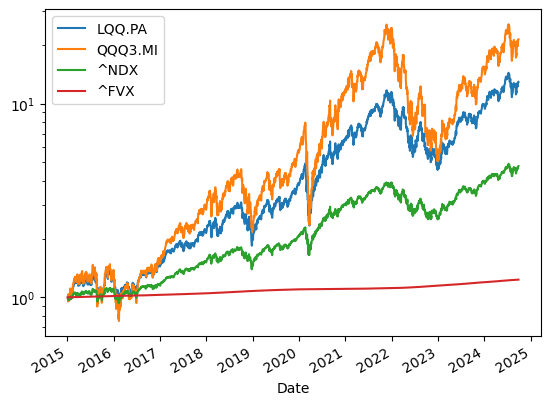

In [3]:


# Tickers to download
tickers   = ["LQQ.PA", "QQQ3.MI", "^NDX"]   # 2x Levearged NASDAQ100, 3x Levearged NASDAQ100, NASDAQ100
risk_free = ["^FVX"]                        # US treasury yield (5 years)

# Download the data from yf
data      = yf.download(tickers+risk_free,group_by='Date', start="2015-01-01", end="2024-09-27")

# Calculate the number of years and estimate the trading days per year
num_years               = (data.index[-1]-data.index[0]).days/365
trading_days_in_year    = int(len(data.index)/num_years)

# For every ticker in the list, forward-fill the empty days and generate a column of percentual change
for t in tickers:
    data[(t, 'Adj Close')] = data[(t, 'Adj Close')].ffill()
    data[(t,'Pct Change')] = data[(t, 'Adj Close')].pct_change()
# The tickers in the risk_free list represent percentual changes thus they need to be treated differently
for t in risk_free:
    data[(t, 'Adj Close')]  = data[(t, 'Adj Close')].ffill()
    data[(t, 'Pct Change')] = data[(t,'Adj Close')].div(100*trading_days_in_year)
    data[(t, 'Adj Close')]  = data[(t, 'Pct Change')].add(1).cumprod()
# Sort again the indexes (after adding new columns)
data.sort_index(axis=1, inplace=True) 

# Plot data
for t in tickers+risk_free:
    data[(t,'Pct Change')].add(1).cumprod().plot(label=t)

plt.yscale('log')
plt.legend()
plt.show()

In [5]:
print(f"Period: {num_years:.1f} years")
riskfree_return =  ((data[('^FVX', 'Adj Close')].iloc[-1]/data[('^FVX', 'Adj Close')].iloc[0])**(1/num_years)-1)
print(f"Annualized risk-free return: {100*riskfree_return:.1f} %")
for t in tickers:
    print(f"Ticker: {t}")
    excess_returns      = (data[(t, 'Adj Close')].iloc[-1]/data[(t, 'Adj Close')].iloc[0])**(1/num_years)-1 -riskfree_return
    standard_deviation  = data[(t, 'Pct Change')].std() * (trading_days_in_year**0.5)
    sharpe_ratio        = excess_returns / standard_deviation
    currmax = maximum_drowdown= 0
    for i in range(len(data.index)):
        currmax = max(currmax, data[(t, 'Adj Close')].iloc[i])
        maximum_drowdown = min(maximum_drowdown, (data[(t, 'Adj Close')].iloc[i]-currmax)/currmax)
    print(f"    Excess return      = {100*excess_returns:.1f} %")
    print(f"    Maximum drowdown   = {-100*maximum_drowdown:.1f} %")
    print(f"    Standard deviation = {100*standard_deviation:.1f} %")
    print(f"    Sharpe ratio       = {sharpe_ratio:.2f}")
    print("-------")

Period: 9.7 years
Annualized risk-free return: 2.2 %
Ticker: LQQ.PA
    Excess return      = 27.9 %
    Maximum drowdown   = 61.2 %
    Standard deviation = 39.7 %
    Sharpe ratio       = 0.70
-------
Ticker: QQQ3.MI
    Excess return      = 34.8 %
    Maximum drowdown   = 80.3 %
    Standard deviation = 59.6 %
    Sharpe ratio       = 0.58
-------
Ticker: ^NDX
    Excess return      = 15.2 %
    Maximum drowdown   = 35.6 %
    Standard deviation = 22.1 %
    Sharpe ratio       = 0.69
-------


In [63]:
# We perform the analysis for different lenght of the moving average window
windows = [ 150, 180, 200, 220]
for w in windows:
    signal = data[('^NDX', 'Adj Close')]>data[('^NDX', 'Adj Close')].rolling(window = w).mean()
    data[('MyStrategy', 'Pct Change')] = np.where(signal.shift(1), data[('LQQ.PA', 'Pct Change')], data[('^FVX', 'Pct Change')])
    data[('MyStrategy', 'Adj Close')] = data[('MyStrategy', 'Pct Change')].add(1).cumprod()

    num_years               = (data.index[-1]-data.index[w]).days/365

    excess_returns      = (data[('MyStrategy', 'Adj Close')].iloc[-1]/data[('MyStrategy', 'Adj Close')].iloc[w])**(1/num_years)-1 -riskfree_return
    standard_deviation  = data[('MyStrategy', 'Pct Change')].std() * (trading_days_in_year**0.5)
    sharpe_ratio        = excess_returns / standard_deviation
    print(f"Window size: {w} days")
    print(f"    Excess return      = {100*excess_returns:.1f} %")
    print(f"    Standard deviation = {100*standard_deviation:.1f} %")
    print(f"    Sharpe ratio       = {sharpe_ratio:.2f}")
    print("-------")

KeyError: ('^NDX', 'Adj Close')

In [7]:
# We perform the analysis for different lenght of the moving average window
windows = [ 150, 180, 200, 220]
for w in windows:
    signal = data[('^NDX', 'Adj Close')]>data[('^NDX', 'Adj Close')].rolling(window = w).mean()
    data[('MyStrategy', 'Pct Change')] = np.where(signal.shift(1), data[('QQQ3.MI', 'Pct Change')], data[('^FVX', 'Pct Change')])
    data[('MyStrategy', 'Adj Close')] = data[('MyStrategy', 'Pct Change')].add(1).cumprod()

    num_years               = (data.index[-1]-data.index[w]).days/365

    excess_returns      = (data[('MyStrategy', 'Adj Close')].iloc[-1]/data[('MyStrategy', 'Adj Close')].iloc[w])**(1/num_years)-1 -riskfree_return
    standard_deviation  = data[('MyStrategy', 'Pct Change')].std() * (trading_days_in_year**0.5)
    sharpe_ratio        = excess_returns / standard_deviation
    print(f"Window size: {w} days")
    print(f"    Excess return      = {100*excess_returns:.1f} %")
    print(f"    Standard deviation = {100*standard_deviation:.1f} %")
    print(f"    Sharpe ratio       = {sharpe_ratio:.2f}")
    print("-------")

Window size: 150 days
    Excess return      = 51.4 %
    Standard deviation = 44.5 %
    Sharpe ratio       = 1.16
-------
Window size: 180 days
    Excess return      = 56.5 %
    Standard deviation = 44.3 %
    Sharpe ratio       = 1.28
-------
Window size: 200 days
    Excess return      = 58.9 %
    Standard deviation = 44.4 %
    Sharpe ratio       = 1.33
-------
Window size: 220 days
    Excess return      = 51.8 %
    Standard deviation = 44.3 %
    Sharpe ratio       = 1.17
-------


In [61]:

data.head

<bound method NDFrame.head of                     Open          High           Low         Close  \
Date                                                                 
1985-10-01    110.620003    112.160004    110.565002    112.139999   
1985-10-02    112.139999    112.540001    110.779999    110.824997   
1985-10-03    110.839996    111.184998    110.120003    110.870003   
1985-10-04    110.870003    110.870003    109.855003    110.074997   
1985-10-07    110.074997    110.135002    108.175003    108.199997   
...                  ...           ...           ...           ...   
2024-09-24  19917.560547  19984.470703  19739.669922  19944.839844   
2024-09-25  19922.279297  20043.429688  19921.220703  19972.609375   
2024-09-26  20273.300781  20273.300781  19966.990234  20115.539062   
2024-09-27  20147.279297  20152.529297  19964.130859  20008.619141   
2024-09-30  19959.259766  20072.429688  19852.849609  20060.689453   

               Adj Close      Volume  
Date                

In [12]:
r = scipy.stats.mannwhitneyu(results[results['above']==False]['volatility'], results[results['above']==True]['volatility'], alternative='greater')


In [15]:
print(f"{r.pvalue}")

1.3274920818640852e-20:.2f


In [2]:
trading_days_in_year

258